#### Imports are Necessary

In [1]:
import torch
from rpn.build_rpn import RPN_Model
from sam.build_sam import SAM_Model
from data_builder.build_dataset import ParcelDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#### Usual Definition

In [2]:
ROOT_PATH = 'dataset/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Model Definition

In [4]:
rpn_model = RPN_Model('rpn/checkpoint/rpn_model_2023-07-10 15:31:41.507089.pth', 2, device)
sam_model = SAM_Model('sam/checkpoint/sam_vit_b_01ec64.pth', 'base', device)

#### Dataset Definition

In [5]:
dataset = ParcelDataset(ROOT_PATH, train=False)

In [6]:
rgb_image, transformed_image, target = dataset[3000]

#### Region Proposal Network

In [7]:
predictions = rpn_model.predict(transformed_image)
predictions = rpn_model.postprocess(predictions, nms_threshold=0.9, score_threshold=0.6)

#### Segment Anything Model

In [8]:
low_res_masks, iou_predictions = sam_model.predict(rgb_image, predictions['boxes'])
high_res_masks = sam_model.postprocess(low_res_masks, tuple(rgb_image.size))
high_res_masks = high_res_masks.squeeze().cpu().numpy()

#### Plot the Predicted & Ground Truth Boxes

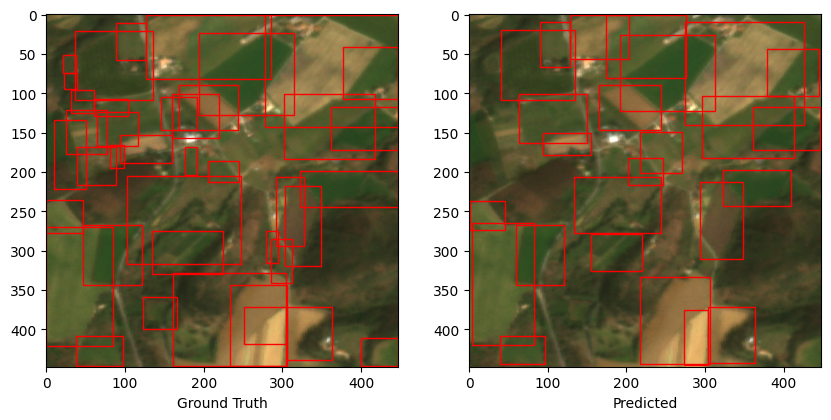

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(rgb_image)
ax[0].set_xlabel('Ground Truth')

for i in range (len(target['boxes'])):
    xmin = target['boxes'][i][0]
    ymin = target['boxes'][i][1]
    xmax = target['boxes'][i][2]
    ymax = target['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

ax[1].imshow(rgb_image)
ax[1].set_xlabel('Predicted')

for i in range (len(predictions['boxes'])):
    xmin = predictions['boxes'][i][0]
    ymin = predictions['boxes'][i][1]
    xmax = predictions['boxes'][i][2]
    ymax = predictions['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

plt.show()

#### Plot the Predicted & Ground Truth Masks

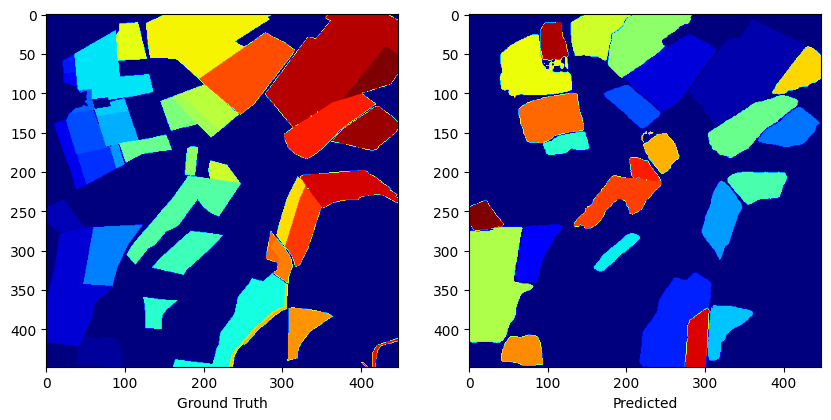

In [24]:
cumulative_high_mask = np.zeros(tuple(rgb_image.size), dtype=np.uint8)

delta_pred_mask = 255 // len(high_res_masks)

for i, mask in enumerate(high_res_masks):
    cumulative_high_mask[mask > 0] = (i + 1)*delta_pred_mask


cumulative_gt_mask = np.zeros(tuple(rgb_image.size), dtype=np.uint8)
delta = 100 // len(target['masks'])

for i, mask in enumerate(target['masks']):
    cumulative_gt_mask[mask > 0] = (i + 1)*delta


#Plot both masks
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(cumulative_gt_mask, cmap='jet')
ax[0].set_xlabel('Ground Truth')

ax[1].imshow(cumulative_high_mask, cmap='jet')
ax[1].set_xlabel('Predicted')

plt.show()